In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import json

In [2]:
def l2d(arr):
    return {x: x for x in arr}

def read_df(tag2path, samples):
    dfs = []
    for tag, path in tag2path.items():
        for sample in range(samples):
            try:
                with open(f"outputs/{path}_{sample}/config.json") as f:
                    config = json.load(f)
                    rate = config["fit"]["optimizer"]["learning_rate"] / config["dataset"]["train"]["batch_size"]
                df = pd.read_json(f"outputs/{path}_{sample}/logs.json")
                df["tag"] = tag
                df["sample"] = sample
                df["epoch"] = (df.index + 1) * rate
                df["train_reg"] = df["train_loss"] - df["train_ce"]
                df["eval_reg"] = df["eval_loss"] - df["eval_ce"]
                dfs.append(df)
            except:
                pass
    return pd.concat(dfs)

def agg_df(df_src, s):
    df_list = []
    for c in s:
        df = df_src.copy()
        df["tag"] = df["tag"].apply(lambda s: f"p{c}" if c in s else f"n{c}")
        df = df.groupby(["tag", "epoch"]).mean().reset_index().set_index("epoch")
        df_list.append(df)
    return pd.concat(df_list)
def outer(x):
    return x.unsqueeze(-1) * x.unsqueeze(-2)

def std(m1, m2):
    return (m2.diagonal() - m1.square()).clip(min=0).sqrt()

def cov(m1, m2):
    return m2 - outer(m1)

def corr(m1, m2):
    return cov(m1, m2) / outer(std(m1, m2))

def corr2(m1, m2):
    return m2 / outer(m2.diagonal().sqrt())

def lin_map(x, s):
    return x.clamp(-s, s), (-s, s)

def inf_map(x, s):
    a = np.pi / 2
    return (x / s * a).arctan() / a, (-1, 1)

def read_state(state, i, sign):
    sym = "n" if sign else "s"
    s0 = state[f"{i}.train_agg.s0"]
    s1 = state[f"{i}.train_agg.{sym}1"]
    s2 = state[f"{i}.train_agg.{sym}2"]
    return s1 / s0, s2 / s0

def read_weight(state, i, flip):
    w = state[f"{i}.weight"]
    if flip:
        w = w.T
    return w.mean(0), w.T @ w

In [30]:
#tag2path = [f"schemes/{s}_{l}" for s in ("none", "base", "mean", "cov-mc", "cov-quad") for l in ("all",)]
#tag2path = [f"cov/cov_{l}_b{b}_o{o}_c{c}" for l in ("mc",) for b in (0, 1) for o in (0, 1, 2) for c in (1,)]
#tag2path = {s: f"cov/cov_mc_b0_o2_c0{s}" for s in ("", "_lsg", "_wsg", "_psg")}
#tag2path = {s: f"cov/cov_mc_b0_o2_c0{s}_l2" for s in ("", "_xsg", "_wsg", "_psg", "_lsg", "_gsg", "_hsg")}
#tag2path = {f"{b}_{o}_{c}": f"dis/cov_mc_{b}_{o}_{c}" for o in ("o1", "o2") for b in ("b0", "b1") for c in ("c0", "c1")}
#tag2path = {l: f"cov/cov_mc_b1_o2_c1_{l}" for l in ("l", "l1", "l2", "l3", "l123")}
#tag2path = {f"{l}": f"lyr/mean_{l}" for l in ("l", "l1", "l2", "l3", "l123")}
#tag2path = {f"{l}": f"lyr/mean_sigmoid_{l}" for l in ("l", "l1", "l2", "l3", "l123")}
#tag2path = {f"{l}_{b}": f"hpo/mean_s0.0_{l}_{b}" for l in ("l2e-3", "l5e-3", "l1e-2") for b in ("b50", "b100", "b200")}
#tag2path = {"mean": "cov/mean_l123", "cov": "cov/cov_mc_b1_o2_c1_l123"}
#tag2path = {f"b{e}": f"epc/mean_tanh_e{e}" for e in (0, 10, 20, 30, 40)}
tag2path = {f"{m}": f"lyr/{m}_l123" for m in ("mean_relu", "cov_relu", "cov_quad_relu", "mean_tanh", "cov_erf-t", "cov_quad_erf-t")}

samples = 10
epochs = (30,)
#states, linears = (3, 6, 9, 11), (1, 4, 7, 10)
states, linears = (4, 8, 12, 14), (1, 5, 9, 13)
#states, linears = (2, 6, 10, 14), (1, 5, 9, 13)
tags_paths_epochs = [(tag, path, epoch) for tag, path in tag2path.items() for epoch in epochs]
layers = [f"layer {i+1}" for i in range(3)]

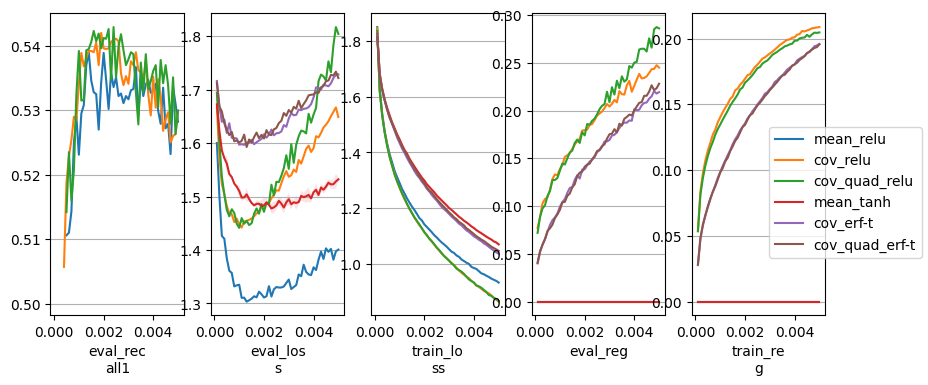

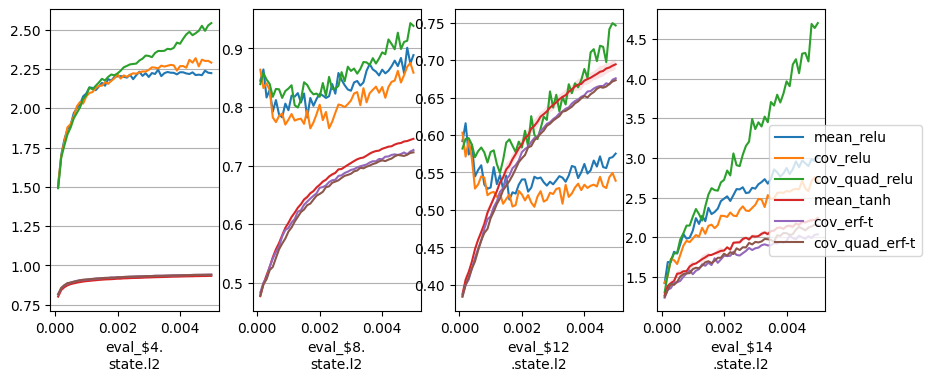

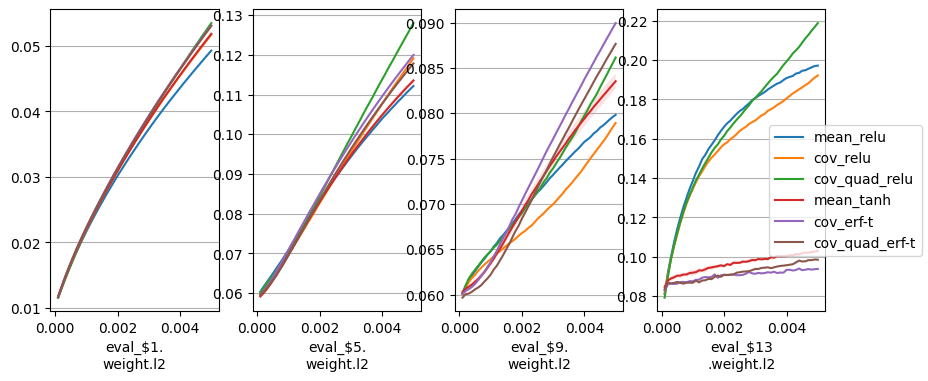

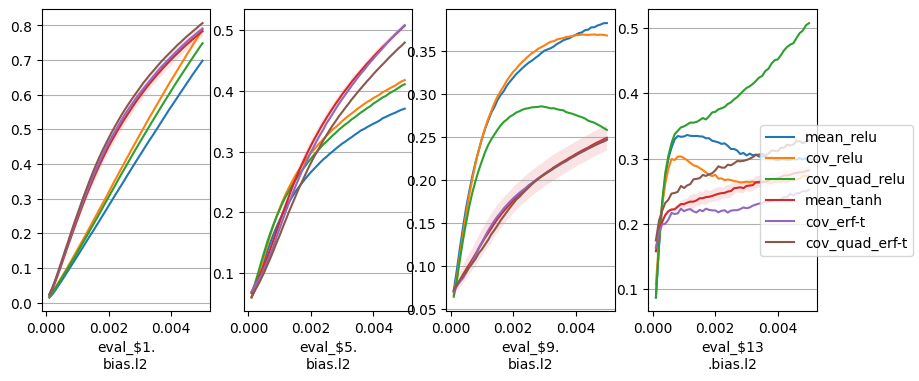

In [32]:
def rowplots(df, labels, start=0, stop=50, sharex=True, sharey=False):
    fig, axes = plt.subplots(
        1, len(labels), figsize=(10, 4),
        sharex=sharex, sharey=sharey, 
        facecolor="w", dpi=100)
    if len(labels) == 1:
        axes = [axes]
    df = df[(df.index >= start)&(df.index < stop)]
    df_mean = df.groupby(["tag", "epoch"], sort=False).mean().reset_index().set_index("epoch").groupby("tag", sort=False)
    df_var = df.groupby(["tag", "epoch"], sort=False).var().reset_index().set_index("epoch").groupby("tag", sort=False)
    for ax, label in zip(axes, labels):
        ax.set_xlabel(f"{label[:8]}\n{label[8:]}")
        ax.grid(axis="y")
        #ax.set_xscale("log")
        for (tag, mean), (_, var) in zip(df_mean[label], df_var[label]):
            std = np.sqrt(var)
            ax.plot(mean.index, mean, label=tag)
            ax.fill_between(mean.index, mean-std, mean+std, alpha=0.125)
        #ax.set_ylim(bottom=0)
    fig.legend(*axes[0].get_legend_handles_labels(), "right")

df = read_df(tag2path, samples)
df["eval_recall1"] = df["eval_recall1"].mask(df["eval_recall1"] < 0.50)
rowplots(df, ["eval_recall1", "eval_loss", "train_loss", "eval_reg", "train_reg"])
#rowplots(df, [f"eval_${i}.state.l0" for i in states])
rowplots(df, [f"eval_${i}.state.l2" for i in states])
rowplots(df, [f"eval_${i}.weight.l2" for i in linears])
rowplots(df, [f"eval_${i}.bias.l2" for i in linears])
None

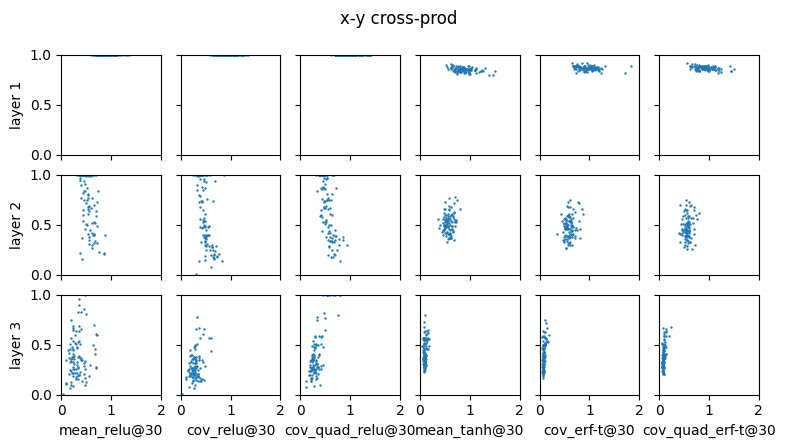

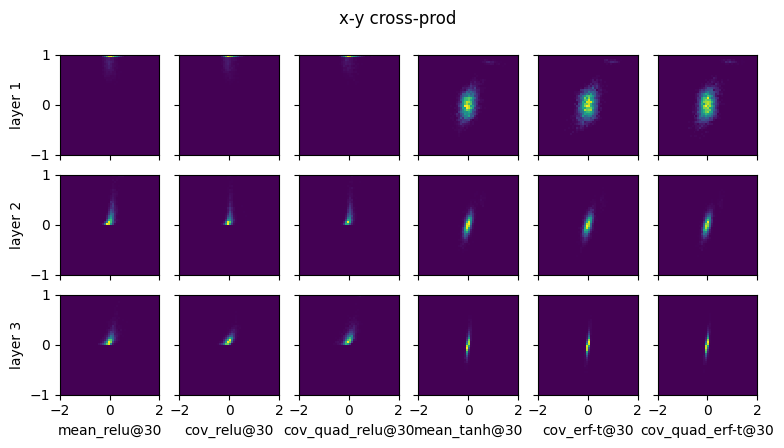

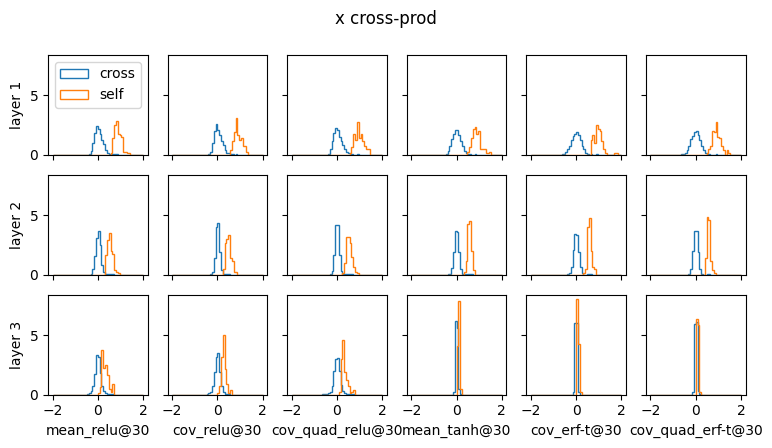

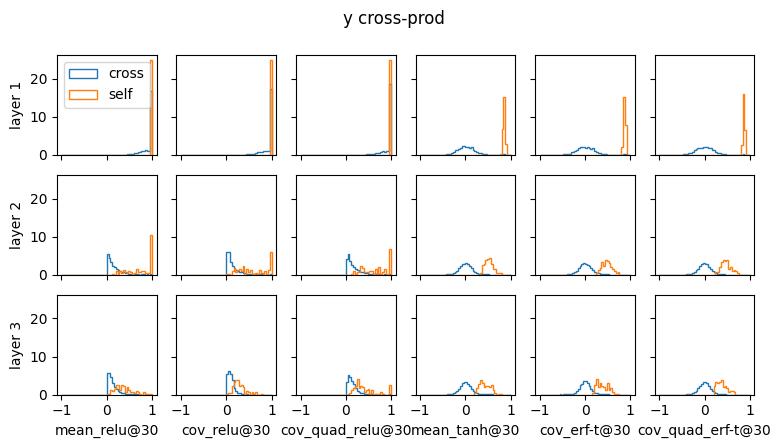

In [33]:
def gridplot(title, xlabels, ylabels):
    nrows, ncols = len(ylabels), len(xlabels)
    fig, axes = plt.subplots(
        nrows, ncols, sharex=True, sharey=True, 
        figsize=(ncols*1.5, nrows*1.5), dpi=100, facecolor="w")
    fig.suptitle(title)
    for i in range(ncols):
        axes[nrows-1][i].set_xlabel(xlabels[i])
    for i in range(nrows):
        axes[i][0].set_ylabel(ylabels[i])
    return axes

def hist2d_plot(ax1, ax2, x, y, range, bins):
    ax2.hist2d(x.flatten().numpy(), y.flatten().numpy(), range=range, bins=bins, density=True)
    ax1.scatter(x.diagonal().numpy(), y.diagonal().numpy(), s=0.5)
    ax1.set_xlim(0, range[0][1])
    ax1.set_ylim(0, range[1][1])

def hist1d_plot(ax, x, range, bins):
    ax.hist(x.flatten().numpy(), label="cross", range=range, bins=bins, histtype="step", density=True)
    ax.hist(x.diagonal().numpy(), label="self", range=range, bins=bins, histtype="step", density=True)

def setplot(tags_paths_epochs, layers, term, sign, scales, mapping, fn):
    xlabels = [f"{tag}@{epoch}" for tag, _, epoch in tags_paths_epochs]
    ax_xy1 = gridplot(f"x-y {term}", xlabels, layers)
    ax_xy2 = gridplot(f"x-y {term}", xlabels, layers)
    ax_x = gridplot(f"x {term}", xlabels, layers)
    ax_y = gridplot(f"y {term}", xlabels, layers)
    for i, (_, path, epoch) in enumerate(tags_paths_epochs):
        path = f"outputs/{path}_0/checkpoint-{epoch}.pt"
        try:
            state = torch.load(path, map_location="cpu")
        except Exception:
            continue
        for j, layer in enumerate(layers):
            x_m1, x_m2 = read_weight(state["model"], j*4+5, False)
            y_m1, y_m2 = read_state(state["model"], j*4+4, sign)
            #y_m1, y_m2 = read_state(state["model"], j*4+2, sign)
            #y_m1, y_m2 = read_weight(state["model"], j*4+1, True)
            '''x_v = x_m2.diagonal().mean()
            y_v = y_m2.diagonal().mean()
            x_m1, x_m2 = x_m1 / x_v.sqrt(), x_m2 / x_v
            y_m1, y_m2 = y_m1 / y_v.sqrt(), y_m2 / y_v'''
            x, x_range = mapping(fn(x_m1, x_m2), scales[0])
            y, y_range = mapping(fn(y_m1, y_m2), scales[1])
            x_bins, y_bins = 50, 50
            hist2d_plot(ax_xy1[j][i], ax_xy2[j][i], x, y, (x_range, y_range), (x_bins, y_bins))
            hist1d_plot(ax_x[j][i], x, x_range, x_bins)
            hist1d_plot(ax_y[j][i], y, y_range, y_bins)
    ax_x[0][0].legend()
    ax_y[0][0].legend()

term, sign, scales, mapping, fn = "cross-prod", False, (2, 1), lin_map, lambda m1, m2: m2
#term, sign, scales, mapping, fn = "covariance", False, (20, 2), lin_map, cov
#term, sign, scales, mapping, fn = "correlation", False, (1, 1), lin_map, corr
#term, sign, scales, mapping, fn = "biased correlation", False, (1, 1), lin_map, corr2
setplot(tags_paths_epochs, layers, term, sign, scales, mapping, fn)